<a href="https://colab.research.google.com/github/piorrico/task2/blob/main/CUSTOMER_SEGMENTATION_USING_UNSUPERVISED_METHODS_AND_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1)LIBRARY IMPORTATION

In [3]:
#pip install weightedstats


In [4]:
#Library Importation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from datetime import timedelta
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.style as style
import math
from statistics import median
from scipy.stats import skew
import weightedstats as ws
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# 2)DATA IMPORTATION

In [5]:
# Datasets importation from Google Drive folder
#Customer Dataset
customers_url = 'https://drive.google.com/file/d/1trjIdykod5jlh4JCk7ZRSoKXFvovra68/view?usp=share_link'
customers_path = 'https://drive.google.com/uc?export=download&id='+customers_url.split('/')[-2]
customers_data = pd.read_csv(customers_path)
#Geolocation Dataset
geolocation_url = 'https://drive.google.com/file/d/1g635f6qGuFpqtIKe63ss2X6YgOHSLDLR/view?usp=share_link'
geolocation_path = 'https://drive.google.com/uc?export=download&id='+geolocation_url.split('/')[-2]
geolocation_data = pd.read_csv(geolocation_path)
#Items Dataset
items_url = 'https://drive.google.com/file/d/18acVf2ciN0As5Q5GbA2PnO6HyF_dOrz4/view?usp=share_link'
items_path = 'https://drive.google.com/uc?export=download&id='+items_url.split('/')[-2]
items_data = pd.read_csv(items_path)
#Payments Dataset
payments_url = 'https://drive.google.com/file/d/1CH48eJjls-_gfjMPXAAxtx1Sh0cGUq67/view?usp=share_link'
payments_path = 'https://drive.google.com/uc?export=download&id='+payments_url.split('/')[-2]
payments_data = pd.read_csv(payments_path)
#Reviews Dataset
reviews_url = 'https://drive.google.com/file/d/14EEawWIHYafD-kLbJUVeYIM9L-c1nw24/view?usp=share_link'
reviews_path = 'https://drive.google.com/uc?export=download&id='+reviews_url.split('/')[-2]
reviews_data = pd.read_csv(reviews_path)
# Orders Dataset
orders_url = 'https://drive.google.com/file/d/1QVPJERDEvBFq6tLPEvfH-OfhdHOWQV67/view?usp=share_link'
orders_path = 'https://drive.google.com/uc?export=download&id='+orders_url.split('/')[-2]
orders_data = pd.read_csv(orders_path)

# Products Dataset
products_url = 'https://drive.google.com/file/d/1HlLVfY8GrjIxRXsvqm8FaIdJS4WIIL1Q/view?usp=share_link'
products_path = 'https://drive.google.com/uc?export=download&id='+products_url.split('/')[-2]
products_data = pd.read_csv(products_path)
# Sellers Dataset
sellers_url = 'https://drive.google.com/file/d/18s2z6P6noAyaRSK2ttTsU_g3porLucOg/view?usp=share_link'
sellers_path = 'https://drive.google.com/uc?export=download&id='+sellers_url.split('/')[-2]
sellers_data= pd.read_csv(sellers_path)
# Sellers Dataset
category_name_trans_url= 'https://drive.google.com/file/d/12ApARlTizxPK3M9pAmcVbpMhQm5zPuf2/view?usp=share_link'
category_name_trans_path = 'https://drive.google.com/uc?export=download&id='+category_name_trans_url.split('/')[-2]
category_name_trans_data= pd.read_csv(category_name_trans_path)


In [12]:
#Data Understanding of each dataset before merging them. The table present: Total Rows,	Total Columns,	Total Duplicates and 	Total Null

# Datasets names
datasets = [
    customers_data,
    geolocation_data,
    items_data,
    payments_data,
    reviews_data,
    orders_data,
    products_data,
    sellers_data,
    category_name_trans_data
]
titles = [
    "Customers",
    "Geolocation",
    "Items",
    "Payments",
    "Reviews",
    "Orders",
    "Products",
    "Sellers",
    "Category Translation"
]

# Store the data
data_summary = {
    'Name of Dataset': titles,
    'Column names': [', '.join(data.columns) for data in datasets],
    'Total number of  Rows': [data.shape[0] for data in datasets],
    'Total  number of Columns': [data.shape[1] for data in datasets],
    'Duplicates': [data.duplicated().sum() for data in datasets],
    'Null Values': [data.isnull().sum().sum() for data in datasets],
    'Null Columns': [', '.join(data.columns[data.isnull().any()]) for data in datasets]
}

#  Appended Dataframe for analysis
data_summary_df = pd.DataFrame(data_summary)
data_summary_styled = data_summary_df.style.background_gradient(cmap='YlGnBu')

# Print the table with values
data_summary_styled

,Name of Dataset,Column names,Total number of Rows,Total number of Columns,Duplicates,Null Values,Null Columns
0,Customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,Geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,Items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,Payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,Reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,Orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,Products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,Sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,Category Translation,"product_category_name, product_category_name_english",71,2,0,0,


# 3)MERGING THE DATA

In [20]:
other_state_geolocation = geolocation_data.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
other_state_geolocation[other_state_geolocation['count']>= 2].shape
max_state = geolocation_data.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)

In [21]:
geolocation_silver = geolocation_data.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_silver = geolocation_silver.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')

In [22]:
geolocation_silver['geolocation_zip_code_prefix'].nunique()

19015

In [23]:
customers_silver = customers_data.merge(geolocation_silver,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')

In [24]:
customers_data['customer_unique_id'].nunique()

96096

In [25]:
customers_silver['customer_unique_id'].nunique()

95828

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import urllib.request
def plot_brasil_map(data):
    brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
    ax = data.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(10,10), alpha=0.3,s=0.3,c='blue')
    plt.axis('off')
    plt.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
    plt.show()

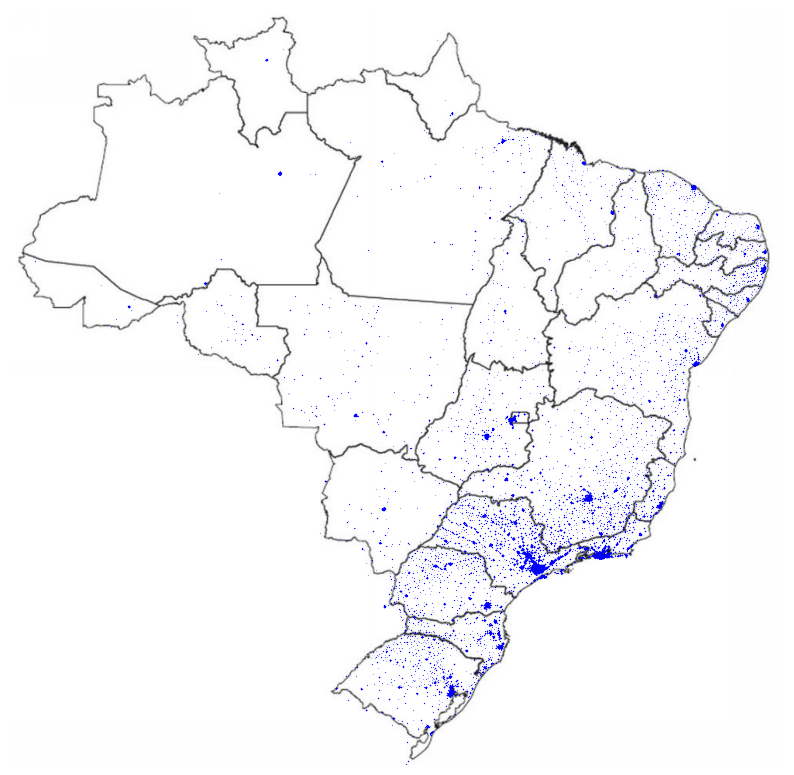

In [27]:
plot_brasil_map(customers_silver.drop_duplicates(subset='customer_unique_id'))

In [28]:
#Datasets merging process with key variables
olist_dataset= pd.merge(customers_data, orders_data, on="customer_id", how='inner')
olist_dataset= olist_dataset.merge(reviews_data, on="order_id", how='inner')
olist_dataset= olist_dataset.merge(items_data, on="order_id", how='inner')
olist_dataset= olist_dataset.merge(products_data, on="product_id", how='inner')
olist_dataset= olist_dataset.merge(payments_data, on="order_id", how='inner')
olist_dataset= olist_dataset.merge(sellers_data, on='seller_id', how='inner')
olist_dataset= olist_dataset.merge(category_name_trans_data, on='product_category_name', how='inner')
#olist_dataset= olist_dataset.merge(geolocation_data, on='customer_zip_code_prefix', how='inner')
olist_dataset.shape



(115609, 40)

Column names of Olist merged dataset

In [29]:
olist_dataset.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name_english'],
      dtype='object')

In [30]:
olist_dataset.describe()

,customer_zip_code_prefix,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,35061.537597,4.034409,1.194535,120.619850,20.056880,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,1.093747,2.946233,172.387379,24515.713958
std,29841.671732,1.385584,0.685926,182.653476,15.836184,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,0.729849,2.781087,265.873969,27636.640968
min,1003.000000,1.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1001.000000
25%,11310.000000,4.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.870000,6429.000000
50%,24241.000000,5.000000,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.050000,13660.000000
75%,58745.000000,5.000000,1.000000,134.900000,21.210000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.480000,28605.000000
max,99980.000000,5.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,99730.000000


In [31]:
olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   order_id                       115609 non-null  object 
 6   order_status                   115609 non-null  object 
 7   order_purchase_timestamp       115609 non-null  object 
 8   order_approved_at              115595 non-null  object 
 9   order_delivered_carrier_date   114414 non-null  object 
 10  order_delivered_customer_date  113209 non-null  object 
 11  order_estimated_delivery_date  115609 non-null  object 
 12  review_id                     

# 4)DATA PREPROCESSING

In [41]:
#Store the Pre processed data in a new dataframe for preprocessing purposes
olist_df=olist_dataset.copy()

## INCONSISTENCIES AND MISSING VALUES TREATMENT

In [43]:
#Convert variables date to appropriate date format
olist_df['order_purchase_timestamp'] = pd.to_datetime(olist_df['order_purchase_timestamp'])
olist_df['order_delivered_customer_date'] = pd.to_datetime(olist_df['order_delivered_customer_date'])
olist_df['order_estimated_delivery_date'] = pd.to_datetime(olist_df['order_estimated_delivery_date'])
olist_df['shipping_limit_date'] = pd.to_datetime(olist_df['shipping_limit_date'])
olist_df['order_delivered_carrier_date'] =pd.to_datetime(olist_df['order_delivered_carrier_date'])
olist_df['order_approved_at'] =pd.to_datetime(olist_df['order_approved_at'])

In [44]:
# Calculate another variable: Total shipping days (to check inconsistencies)
olist_df['total_shipping_days'] = olist_df['order_delivered_customer_date'] - olist_df['order_delivered_carrier_date']

In [45]:
# List of columns to modify
columns_to_modify = [ 'total_shipping_days'
                     ]

# After calculating the total shipping  days, it is necessary to convert the result to number of days format as follows
for col in columns_to_modify:
    olist_df[col] = olist_df[col].apply(lambda x: round(x.total_seconds() / 86400, 4) if isinstance(x, pd.Timedelta) else x)

In [47]:
# Percentage of missing data
missing_data = pd.concat([(olist_df.isnull().sum()), (olist_df.isnull().sum() * 100 / olist_df.isnull().count())], axis=1, keys=['Total', 'Percentage of Missing Values']).sort_values(by='Total', ascending=False)
missing_data

,Total,Percentage of Missing Values
review_comment_title,101808,88.062348
review_comment_message,66703,57.697065
total_shipping_days,2401,2.076828
order_delivered_customer_date,2400,2.075963
order_delivered_carrier_date,1195,1.033657
order_approved_at,14,0.012110
product_width_cm,1,0.000865
product_weight_g,1,0.000865
product_length_cm,1,0.000865
product_height_cm,1,0.000865


In [49]:

# Filter the DataFrame by unique order_id values
filtered_df = olist_df.drop_duplicates(subset='order_id')
# Calculate  the percentage of each order status
order_status_counts = filtered_df['order_status'].value_counts()
order_status_percentages = filtered_df['order_status'].value_counts(normalize=True) * 100

# On a new dataframe, store the results
order_status_summary = pd.DataFrame({
    'Order Status Count': order_status_counts,
    'Order Status Percentage': order_status_percentages.round(2)
})

# Print the results of the table
order_status_summary


,Order Status Count,Order Status Percentage
delivered,94488,97.90
shipped,1008,1.04
canceled,428,0.44
invoiced,300,0.31
processing,284,0.29
unavailable,6,0.01
approved,2,0.00


In [50]:
#Select only the orders that are labelled as delivered
olist_df = olist_df[olist_df['order_status'] == 'delivered']

In [52]:
# Order status of orders where: order delivered carrier date and order deliveres customer date are null
selected_rows = olist_df.loc[olist_df['order_delivered_carrier_date'].isna() & olist_df['order_delivered_customer_date'].isna()]

status_counts = selected_rows['order_status'].value_counts()

print(status_counts)


delivered    1
Name: order_status, dtype: int64


In [55]:
#Negative values of total shipping days(inconsitencies)
negative_shipping_days_rows = olist_df[olist_df['total_shipping_days'] < 0]
negative_shipping_days_rows.count()['total_shipping_days']

58

In [56]:
#Drop all the shipping days that are less than 0(date inconsistencies)
olist_df = olist_df[olist_df['total_shipping_days'] >= 0]

In [64]:
# Count of missing Values
print(" \nCount of missing values : \n\n",
      olist_df.isnull().sum())

 
Count of missing values : 

 customer_id                          0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_id                             0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
review_id                            0
review_score                         0
review_comment_title             99650
review_comment_message           65818
review_creation_date                 0
review_answer_timestamp              0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name            

There are 14 orders that have missing values in order_approved_at column but have a status of DELIVERED. Since these rows where delivered, the columns will not be removed.

In [58]:
#Missing values in order delivered carrier date
olist_df.loc[olist_df['order_approved_at'].isna(),
                   ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date','order_status']]

,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_status
4576,2017-02-18 15:52:27,2017-02-23 03:09:14,2017-03-07 13:57:47,delivered
4625,2017-01-19 22:26:59,2017-01-27 11:08:05,2017-02-06 14:22:19,delivered
4694,2017-02-19 01:28:47,2017-02-23 03:11:48,2017-03-02 03:41:58,delivered
18720,2017-01-19 12:48:08,2017-01-25 14:56:50,2017-01-30 18:16:01,delivered
22870,2017-02-18 11:04:19,2017-02-23 07:23:36,2017-03-02 16:15:23,delivered
43176,2017-02-17 15:53:27,2017-02-22 11:31:30,2017-03-03 11:47:47,delivered
51949,2017-02-17 13:05:55,2017-02-22 11:23:11,2017-03-02 11:09:19,delivered
51991,2017-02-18 17:15:03,2017-02-22 11:23:11,2017-03-03 18:43:43,delivered
52021,2017-02-18 16:48:35,2017-02-22 11:23:10,2017-03-09 07:28:47,delivered
88985,2017-02-17 17:21:55,2017-02-22 11:42:51,2017-03-03 12:16:03,delivered


In [59]:

#Fill all the Nan rows from order_approved_at column with Nat(no time)
olist_df['order_approved_at']= olist_df['order_approved_at'].fillna(pd.NaT)

In [61]:
# Drop all the orders that have nan values in order_delivered_customer_date and order_delivered_carrier_date
olist_df= olist_df.drop(olist_df.loc[(olist_df['order_delivered_customer_date'].isna() )
          ].index)

In [ ]:
# Order status of orders where: order delivered carrier date and order deliveres customer date are null
selected_rows = olist_df.loc[olist_df['order_delivered_customer_date'].isna()]

status_counts = selected_rows['order_status'].value_counts()

print(status_counts)

Series([], Name: order_status, dtype: int64)


In [63]:
olist_df['payment_type'].value_counts()

credit_card    83492
boleto         22016
voucher         6013
debit_card      1622
Name: payment_type, dtype: int64

There is one product of the dataset that does not contain information about its size. Therefore it will be removed.

In [ ]:
#Product that has no volume
null_mask = olist_df['product_length_cm'].isnull()
null_rows = olist_df[null_mask]
null_rows

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_length_cm,product_height_cm,product_width_cm,payment_type,payment_value,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,total_shipping_days
27352,1d088dea8732788ec35dd4ee6dd76112,69b2b29382af03e03e486ad307a76000,90160,porto alegre,RS,85f8ad45e067abd694b627859fa57453,delivered,2017-01-29 21:40:02,2017-01-30 22:32:20,2017-02-02 05:04:58,...,NaN,NaN,NaN,credit_card,1961.0,86020,londrina,PR,baby,5.2368


# RFM ANALYSIS

In [ ]:
#Drop the selected product without information
null_mask = olist_df['product_length_cm'].isnull()
null_rows = olist_df[null_mask]
olist_df = olist_df.drop(null_rows.index).reset_index(drop=True)

In [66]:
#Store the Pre processed data in a new dataframe
olist_df_cleaned=olist_df.copy()


In [65]:
olist_df_cleaned['order_purchase_timestamp'].max()

NameError: ignored



*   Recency:
*   Frequency: number of order
*   Monetary:






In [ ]:


# Convert 'order_purchase_timestamp' to datetime type
olist_df_cleaned['order_purchase_timestamp'] = pd.to_datetime(olist_df_cleaned['order_purchase_timestamp'])

# Set the date for analysis
current_date = olist_df_cleaned['order_purchase_timestamp'].max() + pd.DateOffset(days=1)
print(current_date)


2018-08-30 15:00:37


In [ ]:
#Recency calculation df
sorted_recency_df = olist_df_cleaned.sort_values('order_purchase_timestamp', ascending=False)
recency_df = sorted_recency_df.loc[:, ['order_purchase_timestamp', 'customer_unique_id']]
recency_df = olist_df_cleaned.groupby('customer_unique_id').apply(lambda x: pd.Series({
   'order_purchase_timestamp': x['order_purchase_timestamp'].max(),
    'Recency': (current_date - x['order_purchase_timestamp'].max()).days

})).reset_index()

#Sort the recency column
#recency_df  = recency_df.sort_values('Recency', ascending=False)


recency_df


,customer_unique_id,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,115
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,537
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,321
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,288
...,...,...,...
91445,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,447
91446,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,262
91447,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,568
91448,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,119


In [ ]:
#Frequency calculation df
frequency_df2 = pd.DataFrame( olist_df_cleaned.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
frequency_df2.rename(columns={"order_id":"Frequency"}, inplace=True)
#frequency_df

frequency_df=olist_df_cleaned.groupby('customer_unique_id')['product_id'].size().reset_index(name='Frequency')
#Sort the recency column
frequency_df  = frequency_df.sort_values('Frequency', ascending=False)

frequency_df

,customer_unique_id,Frequency
55221,9a736b248f67d166d2fbb006bcb877c3,75
39990,6fbc7cdadbb522125f4b27ae9dee4060,38
89258,f9ae226291893fda10af7965268fb7f6,35
31025,569aa12b73b5f7edeaa6f2a01603e381,26
47750,85963fd37bfd387aa6d915d8a1065486,24
...,...,...
32864,5b97eb89e71d8e7cbe9b3023a4d69f97,1
32863,5b976dd4f77ac841d7027290494b8dbe,1
32862,5b96a6a7d5de5738179accb10c9af8aa,1
32861,5b9603bf6b5ba113060bd41f770c725e,1


In [ ]:
#Monetary Calculation df
monetary_df=olist_df_cleaned.groupby('customer_unique_id')['payment_value'].sum().reset_index(name='Monetary')
#Sort the recency column
monetary_df  = monetary_df.sort_values('Monetary', ascending=False)

monetary_df


,customer_unique_id,Monetary
3655,0a0a92112bd4c708ca5fde585afaa872,109312.64
70122,c402f431464c72e27330a67f7b94d4fb,44048.00
22936,4007669dec559734d6f53e029e360987,36489.24
85676,ef8d54b3797ea4db1d63f0ced6a906e9,30186.00
42284,763c8b1c9c68a0229c42c9fc6f662b93,29099.52
...,...,...
39865,6f5b9d1cdccc4d28f0483a612edecacf,11.63
14505,2878e5b88167faab17d4fb83a986d38b,11.63
64140,b33336f46234b24a613ad9064d13106d,10.89
67635,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07


In [ ]:
monetary_df.count()

customer_unique_id    91450
Monetary              91450
dtype: int64

In [ ]:
#Datasets merging process with key variables
RFM_df= pd.merge(recency_df, frequency_df2, on="customer_unique_id", how='inner')
RFM_df= RFM_df.merge(monetary_df, on="customer_unique_id", how='inner')
RFM_df.describe()

,Recency,Frequency,Monetary
count,91450.000000,91450.000000,91450.000000
mean,237.054073,1.032859,212.248263
std,152.541250,0.206200,631.325605
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,63.830000
50%,218.000000,1.000000,112.830000
75%,345.000000,1.000000,202.657500
max,695.000000,14.000000,109312.640000


In [ ]:
# Compute quantiles for each feature
quantiles = RFM_df.quantile(q=[0.2, 0.4, 0.6, 0.8])

# Assign quartile labels for each feature using apply() method
RFM_Segment = RFM_df.copy()
RFM_Segment['R_Quartile'] = RFM_Segment['Recency'].apply(lambda x: sum(x <= quantiles['Recency'].values) + 1)
RFM_Segment['F_Quartile'] = RFM_Segment['Frequency'].apply(lambda x: sum(x <= quantiles['Frequency'].values) + 1)
RFM_Segment['M_Quartile'] = RFM_Segment['Monetary'].apply(lambda x: sum(x >= quantiles['Monetary'].values) + 1)

# Concatenate the quartile labels to form the RFMClass label
RFM_Segment['RFMClass'] = RFM_Segment['R_Quartile'].map(str) \
                            + RFM_Segment['F_Quartile'].map(str) \
                            + RFM_Segment['M_Quartile'].map(str)


<ipython-input-116-1f92f78336d8>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = RFM_df.quantile(q=[0.2, 0.4, 0.6, 0.8])


In [ ]:
quantiles

,Recency,Frequency,Monetary
0.2,91.0,1.0,56.010
0.4,176.0,1.0,89.660
0.6,268.0,1.0,139.930
0.8,381.0,1.0,238.182


In [ ]:
RFM_Segment['RFMClass'].value_counts()

351    3859
252    3856
151    3790
152    3724
554    3708
353    3653
553    3642
453    3635
551    3627
454    3602
352    3566
451    3550
354    3530
255    3521
552    3520
153    3516
253    3505
452    3495
154    3471
455    3443
251    3429
555    3304
155    3301
254    3278
355    3220
515     342
315     340
415     312
215     291
115     216
314     159
514     158
414     136
214     135
114     118
513      75
213      74
413      72
313      67
113      48
412      31
112      30
212      29
512      26
312      22
111       8
411       7
311       3
211       3
511       3
Name: RFMClass, dtype: int64

In [ ]:
RFM_Segment

,customer_unique_id,order_purchase_timestamp,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,112,1,141.90,4,5,4,454
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,115,1,27.19,4,5,1,451
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,537,1,86.22,1,5,2,152
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,321,1,43.62,2,5,1,251
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,288,1,196.89,2,5,4,254
...,...,...,...,...,...,...,...,...,...
91445,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,447,1,4134.84,1,5,5,155
91446,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,262,1,84.58,3,5,2,352
91447,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,568,1,112.46,1,5,3,153
91448,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,119,1,133.69,4,5,3,453


In [ ]:
RFM_Segment.describe()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
count,91450.000000,91450.000000,91450.000000,91450.000000,91450.000000,91450.000000
mean,237.054073,1.032859,212.248263,3.005774,4.881684,3.000197
std,152.541250,0.206200,631.325605,1.414256,0.677695,1.414105
min,1.000000,1.000000,9.590000,1.000000,1.000000,1.000000
25%,114.000000,1.000000,63.830000,2.000000,5.000000,2.000000
50%,218.000000,1.000000,112.830000,3.000000,5.000000,3.000000
75%,345.000000,1.000000,202.657500,4.000000,5.000000,4.000000
max,695.000000,14.000000,109312.640000,5.000000,5.000000,5.000000


In [ ]:

import pandas as pd

# Check column names and data types
print("Column Names and Data Types Before Merge:")
print("RFM_df columns:", RFM_df.columns)
print("RFM_Segment columns:", RFM_Segment.columns)

# Convert 'customer_unique_id' column to a consistent case
RFM_df['customer_unique_id'] = RFM_df['customer_unique_id'].str.lower()
RFM_Segment['customer_unique_id'] = RFM_Segment['customer_unique_id'].str.lower()

# Merge the RFM class to the RFM_df
RFM_df = pd.merge(RFM_df, RFM_Segment[['customer_unique_id', 'RFMClass']],
                  on='customer_unique_id', how='left')

# Check the merged DataFrame
print("\nMerged DataFrame:")
print(RFM_df)



Column Names and Data Types Before Merge:
RFM_df columns: Index(['customer_unique_id', 'order_purchase_timestamp', 'Recency',
       'Frequency', 'Monetary'],
      dtype='object')
RFM_Segment columns: Index(['customer_unique_id', 'order_purchase_timestamp', 'Recency',
       'Frequency', 'Monetary', 'R_Quartile', 'F_Quartile', 'M_Quartile',
       'RFMClass'],
      dtype='object')

Merged DataFrame:
                     customer_unique_id order_purchase_timestamp  Recency  \
0      0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27      112   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27      115   
2      0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03      537   
3      0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41      321   
4      0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42      288   
...                                 ...                      ...      ...   
91445  fffcf5a5ff07b0908bd4e2dbc735a684      2017-06-08 

Descriptive statistics for Recency:
count    91450.000000
mean       237.054073
std        152.541250
min          1.000000
25%        114.000000
50%        218.000000
75%        345.000000
max        695.000000
Name: Recency, dtype: float64

Skewness value for Recency:
0.45

Descriptive statistics for Frequency:
count    91450.000000
mean         1.032859
std          0.206200
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: Frequency, dtype: float64

Skewness value for Frequency:
10.66

Descriptive statistics for Monetary:
count     91450.000000
mean        212.248263
std         631.325605
min           9.590000
25%          63.830000
50%         112.830000
75%         202.657500
max      109312.640000
Name: Monetary, dtype: float64

Skewness value for Monetary:
71.65



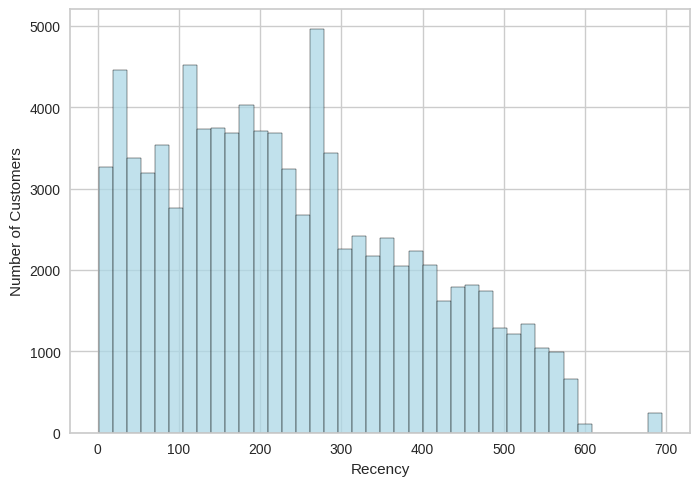

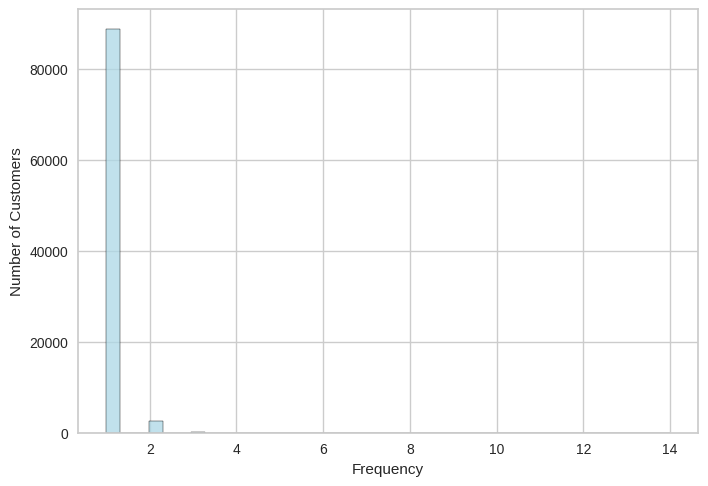

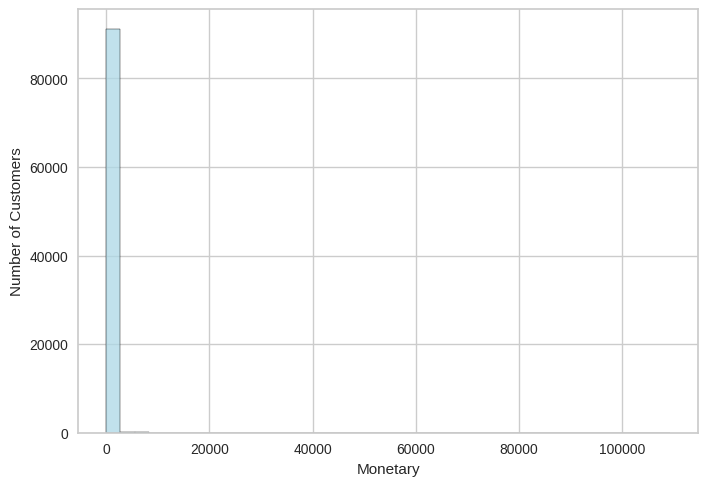

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have an RFM DataFrame named 'RFM_df' with columns 'Recency', 'Frequency', 'Monetary'
# Replace 'RFM_df' with your actual DataFrame containing RFM data
rfm_data = RFM_df

# Perform univariate analysis for each RFM metric
for metric in ['Recency', 'Frequency', 'Monetary']:
    # Calculate descriptive statistics
    statistics = rfm_data[metric].describe()
    print(f"Descriptive statistics for {metric}:\n{statistics}\n")

    # Create a histogram with distribution line
    plt.figure()
    sns.histplot(data=rfm_data, x=metric, bins=40, color='lightblue', edgecolor='black')
    plt.xlabel(metric)
    plt.ylabel('Number of Customers')
    plt.grid(True)  # Add grid

    # Calculate skewness
    skewness = np.round(rfm_data[metric].skew(), 2)
    print(f"Skewness value for {metric}:\n{skewness}\n")


Descriptive statistics for Recency:
count    91450.000000
mean       237.054073
std        152.541250
min          1.000000
25%        114.000000
50%        218.000000
75%        345.000000
max        695.000000
Name: Recency, dtype: float64

Skewness value for Recency:
0.45

Descriptive statistics for Frequency:
count    91450.000000
mean         1.032859
std          0.206200
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: Frequency, dtype: float64

Skewness value for Frequency:
10.66

Descriptive statistics for Monetary:
count     91450.000000
mean        212.248263
std         631.325605
min           9.590000
25%          63.830000
50%         112.830000
75%         202.657500
max      109312.640000
Name: Monetary, dtype: float64

Skewness value for Monetary:
71.65



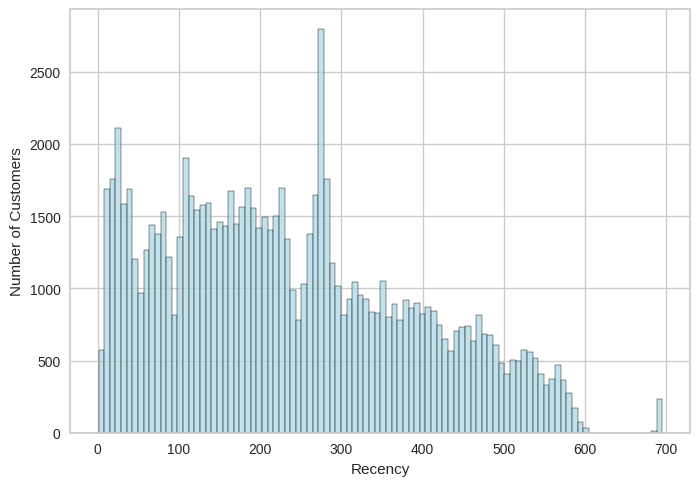

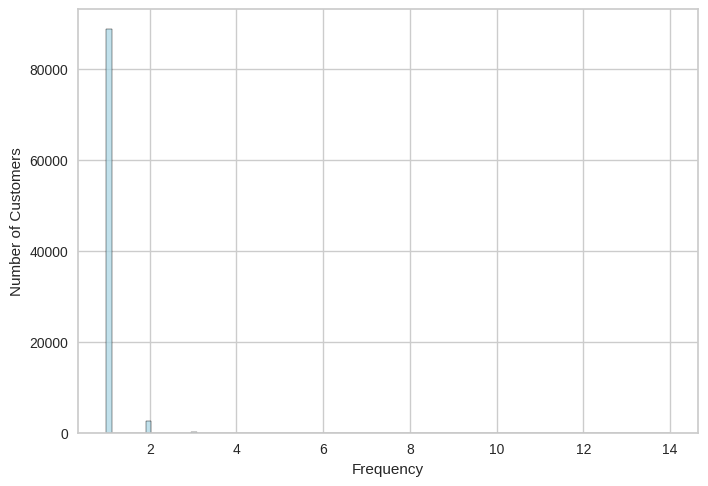

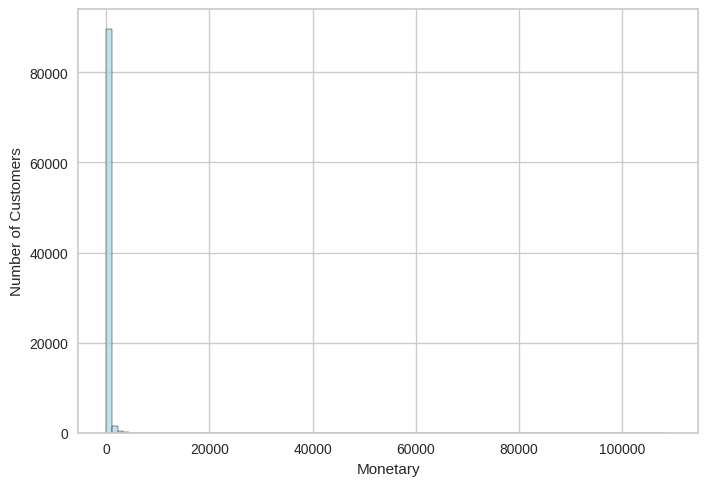

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have an RFM DataFrame named 'RFM_df' with columns 'Recency', 'Frequency', 'Monetary'
# Replace 'RFM_df' with your actual DataFrame containing RFM data
rfm_data = RFM_df

# Perform univariate analysis for each RFM metric
for metric in ['Recency', 'Frequency', 'Monetary']:
    # Calculate descriptive statistics
    statistics = rfm_data[metric].describe()
    print(f"Descriptive statistics for {metric}:\n{statistics}\n")

    # Create a histogram with distribution line
    plt.figure()
    bins = 100  # Specify the number of bins
    sns.histplot(data=rfm_data, x=metric, bins=bins, color='lightblue', edgecolor='black')
    plt.xlabel(metric)
    plt.ylabel('Number of Customers')
    plt.grid(True)  # Add grid

    # Calculate skewness
    skewness = np.round(rfm_data[metric].skew(), 2)
    print(f"Skewness value for {metric}:\n{skewness}\n")


<ipython-input-124-86eaf08a2804>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(RFM_df['Recency'])
<ipython-input-124-86eaf08a2804>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(RFM_df['Frequency'])
<ipython-input-124-86eaf08a2804>:4: UserWarning:

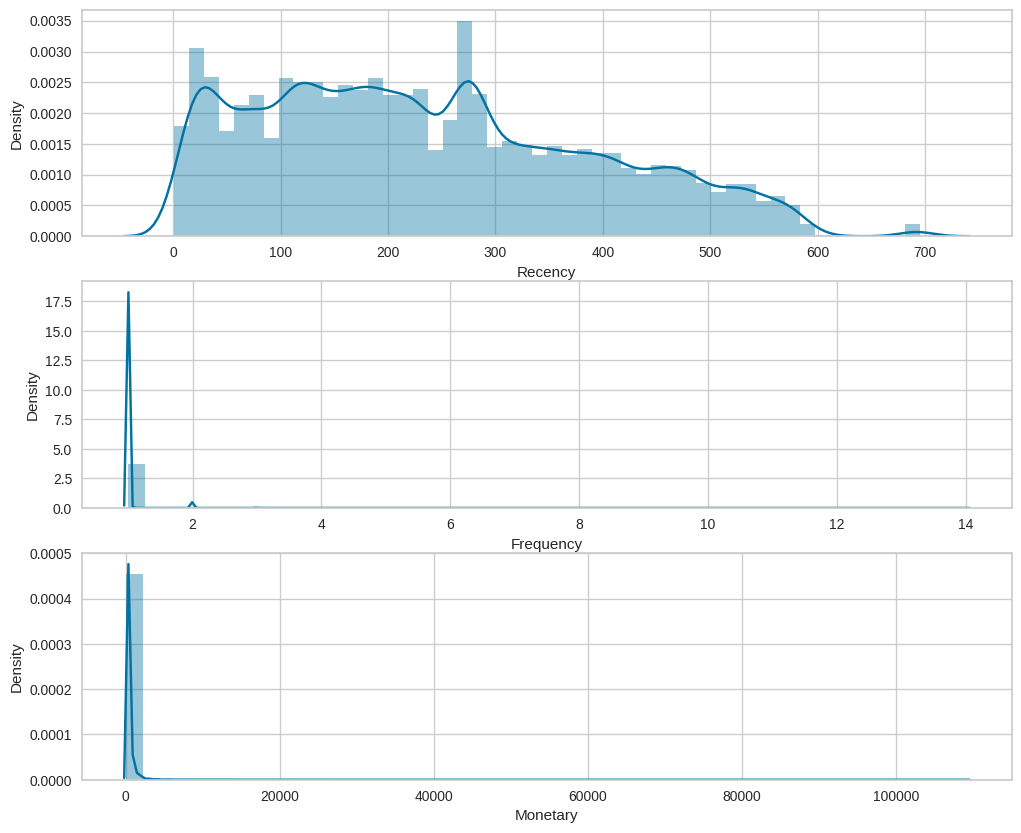

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df['Monetary'])
plt.show()

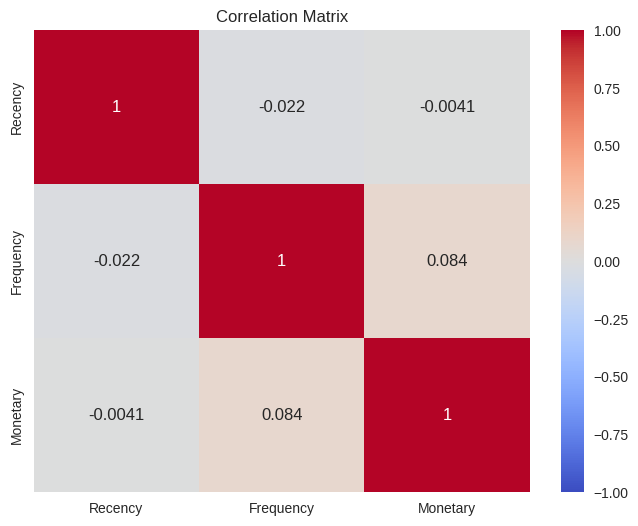

In [ ]:
correlation_matrix = RFM_df[['Recency', 'Frequency', 'Monetary']].corr()


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

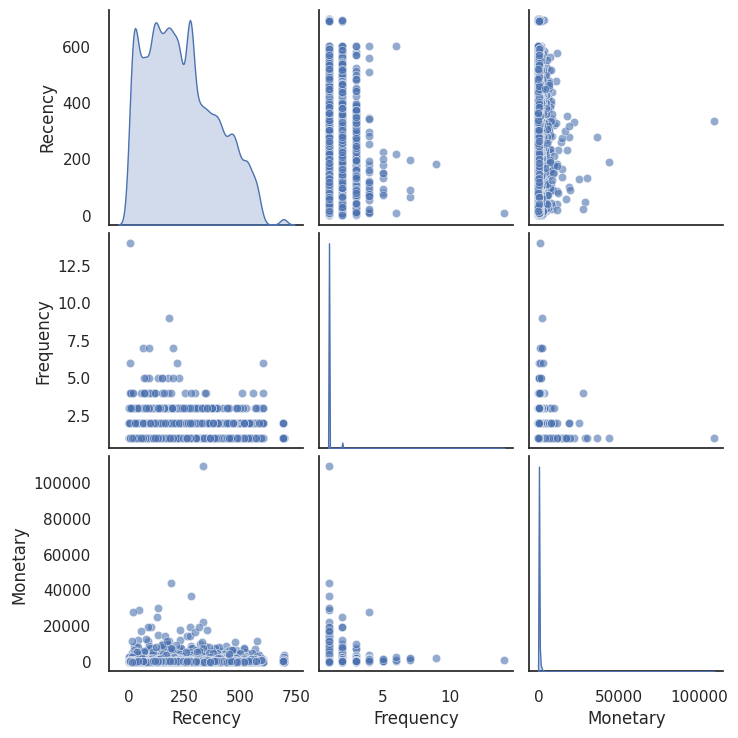

In [ ]:

# Assuming you have an RFM DataFrame named 'RFM_df' with columns 'Recency', 'Frequency', 'Monetary'
# Replace 'RFM_df' with your actual DataFrame containing RFM data

# Calculate the correlation matrix
correlation_matrix = RFM_df[['Recency', 'Frequency', 'Monetary']].corr()

# Plot the correlogram
sns.set(style='white')
sns.pairplot(RFM_df[['Recency', 'Frequency', 'Monetary']], diag_kind='kde', plot_kws={'alpha': 0.6})

plt.show()


In [ ]:
from scipy.stats import kstest

# Select the specific column for distribution check
column_name = 'Recency'
data = RFM_df['Recency']

# Perform Kolmogorov-Smirnov test
statistic, p_value = kstest(data, 'norm')

# Set significance level
alpha = 0.05

# Check distribution
if p_value > alpha:
    print(f"The data in column '{column_name}' follows a normal distribution.")
else:
    print(f"The data in column '{column_name}' does not follow a normal distribution.")


The data in column 'Recency' does not follow a normal distribution.


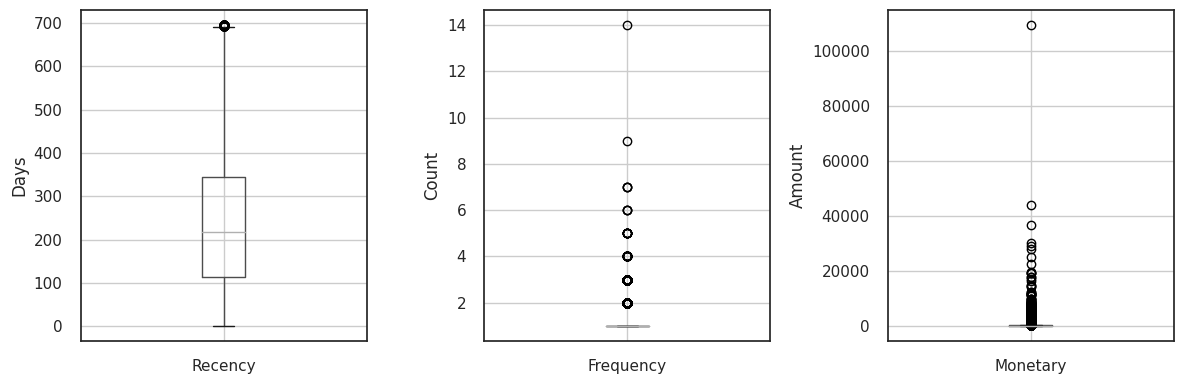

In [ ]:
# with columns 'Recency', 'Frequency', and 'MonetaryValue'

# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot box plots for each variable
RFM_df.boxplot(column='Recency', ax=axes[0])
#axes[0].set_title('Recency')
axes[0].set_ylabel('Days')

rfm_data.boxplot(column='Frequency', ax=axes[1])
#axes[1].set_title('Frequency')
axes[1].set_ylabel('Count')

rfm_data.boxplot(column='Monetary', ax=axes[2])
#axes[2].set_title('Monetary')
axes[2].set_ylabel('Amount')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
from scipy.stats import shapiro

# Assuming you have the RFM data in a pandas DataFrame called 'rfm_data'
# with a column 'Recency'

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(rfm_data['Recency'])

# Print the test results
print('Shapiro-Wilk Test - Recency')
print('Test Statistic:', statistic)
print('p-value:', p_value)

# Interpret the test results
alpha = 0.05  # Set the significance level
if p_value > alpha:
    print('The Recency variable follows a normal distribution.')
else:
    print('The Recency variable does not follow a normal distribution.')

Shapiro-Wilk Test - Recency
Test Statistic: 0.9609517455101013
p-value: 0.0
The Recency variable does not follow a normal distribution.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


      order_purchase_timestamp  Recency  Frequency  Monetary
0          2016-10-03 16:56:50    694.0        1.0     39.09
1          2016-10-03 21:13:36    694.0        1.0     53.73
2          2016-10-03 22:06:03    694.0        1.0    133.46
3          2016-10-03 22:31:31    694.0        1.0     40.95
4          2016-10-03 22:44:10    694.0        1.0    154.57
...                        ...      ...        ...       ...
91213      2018-08-29 12:25:59      0.0        1.0     73.10
91214      2018-08-29 14:18:23      0.0        1.0   1021.92
91215      2018-08-29 14:18:28      0.0        1.0     61.29
91216      2018-08-29 14:52:00      0.0        1.0     33.23
91217      2018-08-29 15:00:37      0.0        1.0     93.75

[91218 rows x 4 columns]


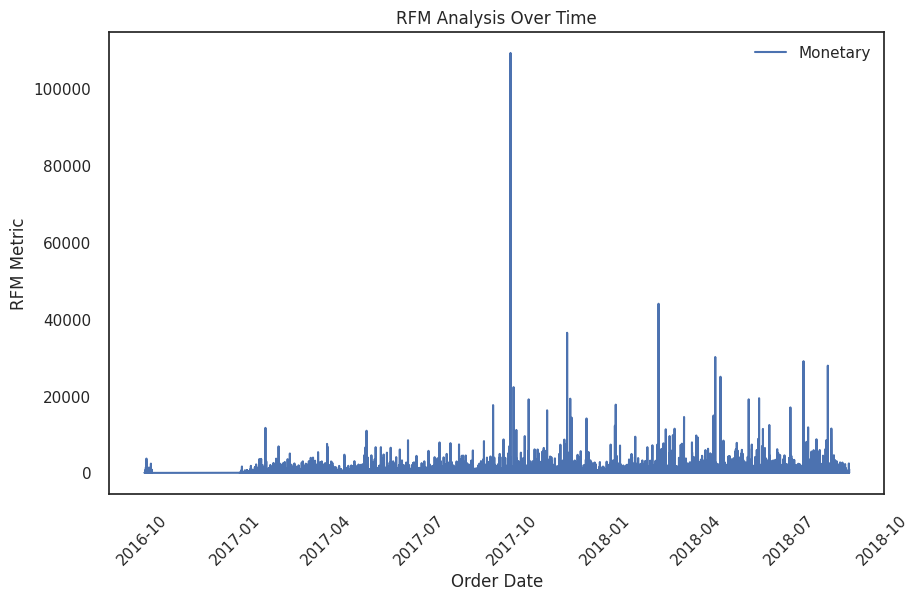

In [ ]:
import pandas as pd

# Assuming you have an RFM DataFrame with columns 'customer_id', 'recency', 'frequency', 'monetary', and 'order_date'
rfm_df = RFM_df

# Convert 'order_date' column to datetime type
rfm_df['order_purchase_timestamp'] = pd.to_datetime(rfm_df['order_purchase_timestamp'])

# Calculate the reference date for analysis
reference_date = rfm_df['order_purchase_timestamp'].max()

# Calculate recency, frequency, and monetary values relative to the reference date
rfm_df['Recency'] = (reference_date - rfm_df['order_purchase_timestamp']).dt.days
rfm_df['Frequency'] = rfm_df['Frequency']
rfm_df['Monetary'] = rfm_df['Monetary']

# Perform RFM analysis over time
rfm_over_time = rfm_df.groupby('order_purchase_timestamp').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(rfm_over_time)
# Convert 'order_date' column to datetime type (if not already done)
rfm_over_time['order_purchase_timestamp'] = pd.to_datetime(rfm_over_time['order_purchase_timestamp'])

# Plotting the results
plt.figure(figsize=(10, 6))
#plt.plot(rfm_over_time['order_purchase_timestamp'], rfm_over_time['Recency'], label='Recency')
#plt.plot(rfm_over_time['order_purchase_timestamp'], rfm_over_time['Frequency'], label='Frequency')
plt.plot(rfm_over_time['order_purchase_timestamp'], rfm_over_time['Monetary'], label='Monetary')
plt.xlabel('Order Date')
plt.ylabel('RFM Metric')
plt.title('RFM Analysis Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# CLUSTER ANALYSIS

In [ ]:
# Select specific columns and store them in another DataFrame
selected_columns_rfm = RFM_df[['customer_unique_id','Recency','Frequency','Monetary']]
selected_columns_rfm.describe()

,Recency,Frequency,Monetary
count,91450.000000,91450.000000,91450.000000
mean,236.054073,1.032859,212.248263
std,152.541250,0.206200,631.325605
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,63.830000
50%,217.000000,1.000000,112.830000
75%,344.000000,1.000000,202.657500
max,694.000000,14.000000,109312.640000


In [ ]:

#unskew the data with data transformations
selected_columns_rfm['Monetary']= np.log(selected_columns_rfm['Monetary'])
#unskew the data with data transformations
#selected_columns_rfm['Frequency']= np.log(selected_columns_rfm['Frequency'])

<ipython-input-132-9a1c034a9d5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns_rfm['Monetary']= np.log(selected_columns_rfm['Monetary'])


<ipython-input-133-da7e2e0b4fa4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_columns_rfm.corr()


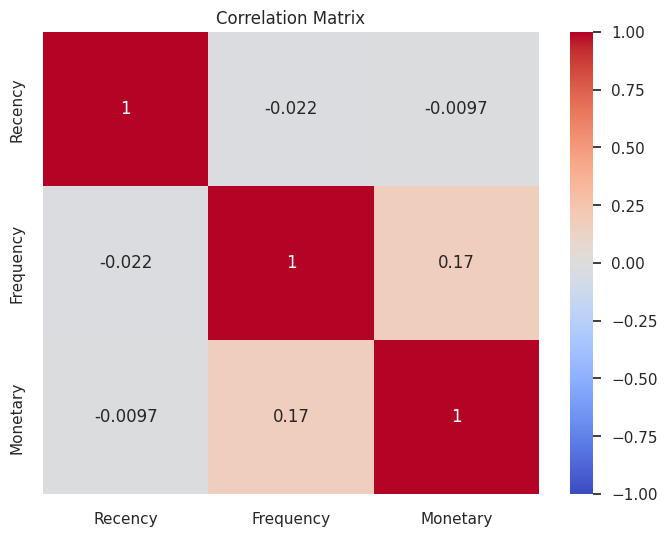

In [ ]:
correlation_matrix = selected_columns_rfm.corr()


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

<ipython-input-134-bb28e7d891ee>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(selected_columns_rfm['Recency'])
<ipython-input-134-bb28e7d891ee>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(selected_columns_rfm['Frequency'])
<ipython-input-134-b

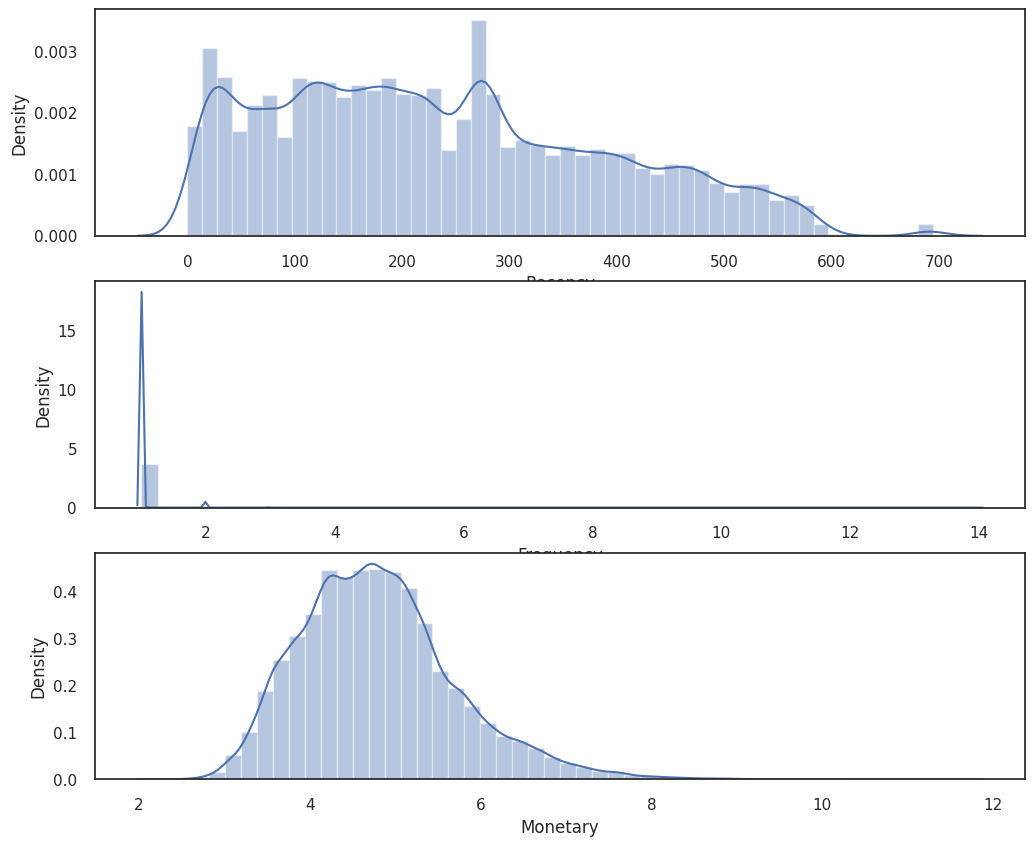

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(selected_columns_rfm['Recency'])
plt.subplot(3, 1, 2); sns.distplot(selected_columns_rfm['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(selected_columns_rfm['Monetary'])
plt.show()

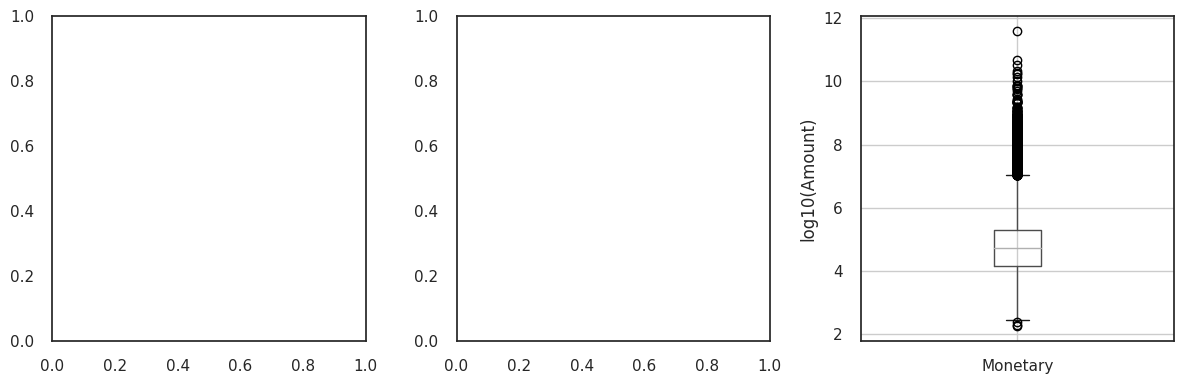

In [ ]:
# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))



selected_columns_rfm.boxplot(column='Monetary', ax=axes[2])

axes[2].set_ylabel('log10(Amount)')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
RFM_log_trans=selected_columns_rfm.copy()

# OUTLIER ANALYSIS

In [ ]:
#OUTLIERS FUNCTIONS
def num_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_df= df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return print("Number of outliers in {} column: ".format(col_name), len(outliers_df)), print("Indexes: ", outliers_df.index)

def erase_outliers_monetary(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr

    outliers_df = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)].copy()
    outliers_df['Cluster'] =4

    df_out = df_in.drop(outliers_df.index)

    print("Number of outliers in {} column: {}".format(col_name, len(outliers_df)))
    print("Indexes:", outliers_df.index)

    return df_out, outliers_df

def erase_outliers_recency(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr

    outliers_df = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)].copy()
    outliers_df['Cluster'] =3

    df_out = df_in.drop(outliers_df.index)

    print("Number of outliers in {} column: {}".format(col_name, len(outliers_df)))
    print("Indexes:", outliers_df.index)

    return df_out, outliers_df

Outlier detection from original RFM data

*   Outliers count in  Monetary column: 8940





In [ ]:
for i in ['Recency','Frequency',"Monetary"]:
    num_outlier(RFM_df, i)
    print("*"*40)

Number of outliers in Recency column:  149
Indexes:  Int64Index([   72,  2408,  2962,  3330,  3942,  4816,  5067,  6105,  6248,
             6369,
            ...
            85370, 85532, 86327, 86464, 88550, 89045, 89209, 89574, 89796,
            91243],
           dtype='int64', length=149)
****************************************
Number of outliers in Frequency column:  2705
Indexes:  Int64Index([  103,   241,   302,   399,   414,   423,   433,   462,   464,
              495,
            ...
            90855, 90869, 90925, 91025, 91029, 91096, 91187, 91288, 91304,
            91407],
           dtype='int64', length=2705)
****************************************
Number of outliers in Monetary column:  8940
Indexes:  Int64Index([    7,    18,    22,    25,    52,    56,    58,    70,    74,
               77,
            ...
            91332, 91359, 91361, 91405, 91416, 91418, 91424, 91439, 91441,
            91445],
           dtype='int64', length=8940)
***********************

Outlier detection from log transformed data


*   Outliers count in  Transformed Monetary column: 1829




In [ ]:
for i in ['Recency','Frequency',"Monetary"]:
    num_outlier(RFM_log_trans, i)
    print("*"*40)

Number of outliers in Recency column:  149
Indexes:  Int64Index([   72,  2408,  2962,  3330,  3942,  4816,  5067,  6105,  6248,
             6369,
            ...
            85370, 85532, 86327, 86464, 88550, 89045, 89209, 89574, 89796,
            91243],
           dtype='int64', length=149)
****************************************
Number of outliers in Frequency column:  2705
Indexes:  Int64Index([  103,   241,   302,   399,   414,   423,   433,   462,   464,
              495,
            ...
            90855, 90869, 90925, 91025, 91029, 91096, 91187, 91288, 91304,
            91407],
           dtype='int64', length=2705)
****************************************
Number of outliers in Monetary column:  1806
Indexes:  Int64Index([   22,   128,   197,   220,   225,   254,   255,   286,   411,
              432,
            ...
            91111, 91135, 91183, 91227, 91248, 91278, 91298, 91359, 91439,
            91445],
           dtype='int64', length=1806)
***********************

In [ ]:
#Remove outliers in a separate dataframe
# RFM_log_trans_wo will contain the input DataFrame with outliers removed
# 'outliers' will contain the removed outliers in a separate DataFrame
RFM_log_trans_wo, outliers = erase_outliers_monetary(RFM_log_trans, 'Monetary')



Number of outliers in Monetary column: 1806
Indexes: Int64Index([   22,   128,   197,   220,   225,   254,   255,   286,   411,
              432,
            ...
            91111, 91135, 91183, 91227, 91248, 91278, 91298, 91359, 91439,
            91445],
           dtype='int64', length=1806)


In [ ]:
RFM_log_trans_wo, outliers2 = erase_outliers_recency(RFM_log_trans_wo, 'Recency')

Number of outliers in Recency column: 146
Indexes: Int64Index([   72,  2408,  2962,  3330,  3942,  4816,  5067,  6105,  6248,
             6369,
            ...
            85370, 85532, 86327, 86464, 88550, 89045, 89209, 89574, 89796,
            91243],
           dtype='int64', length=146)


In [ ]:


outliers2.describe()

,Recency,Frequency,Monetary,Cluster
count,146.000000,146.000000,146.000000,146.0
mean,692.404110,1.006849,4.890681,3.0
std,1.054244,0.082761,0.900384,0.0
min,691.000000,1.000000,2.924236,3.0
25%,691.000000,1.000000,4.268461,3.0
50%,693.000000,1.000000,4.784235,3.0
75%,693.000000,1.000000,5.533139,3.0
max,694.000000,2.000000,6.994089,3.0


In [ ]:
for i in ['Recency','Frequency',"Monetary"]:
    num_outlier(RFM_log_trans_wo, i)
    print("*"*40)

Number of outliers in Recency column:  0
Indexes:  Int64Index([], dtype='int64')
****************************************
Number of outliers in Frequency column:  2520
Indexes:  Int64Index([  103,   241,   302,   399,   414,   423,   462,   464,   495,
              538,
            ...
            90817, 90855, 90869, 91025, 91029, 91096, 91187, 91288, 91304,
            91407],
           dtype='int64', length=2520)
****************************************
Number of outliers in Monetary column:  288
Indexes:  Int64Index([   77,   153,  1613,  1638,  1772,  2488,  2498,  2990,  3138,
             3243,
            ...
            88985, 89196, 89259, 89391, 89869, 89906, 90125, 90538, 90742,
            91022],
           dtype='int64', length=288)
****************************************


<ipython-input-144-8cc530cb68ae>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(outliers['Recency'])
<ipython-input-144-8cc530cb68ae>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(outliers['Frequency'])
<ipython-input-144-8cc530cb68ae>:6: UserWarn

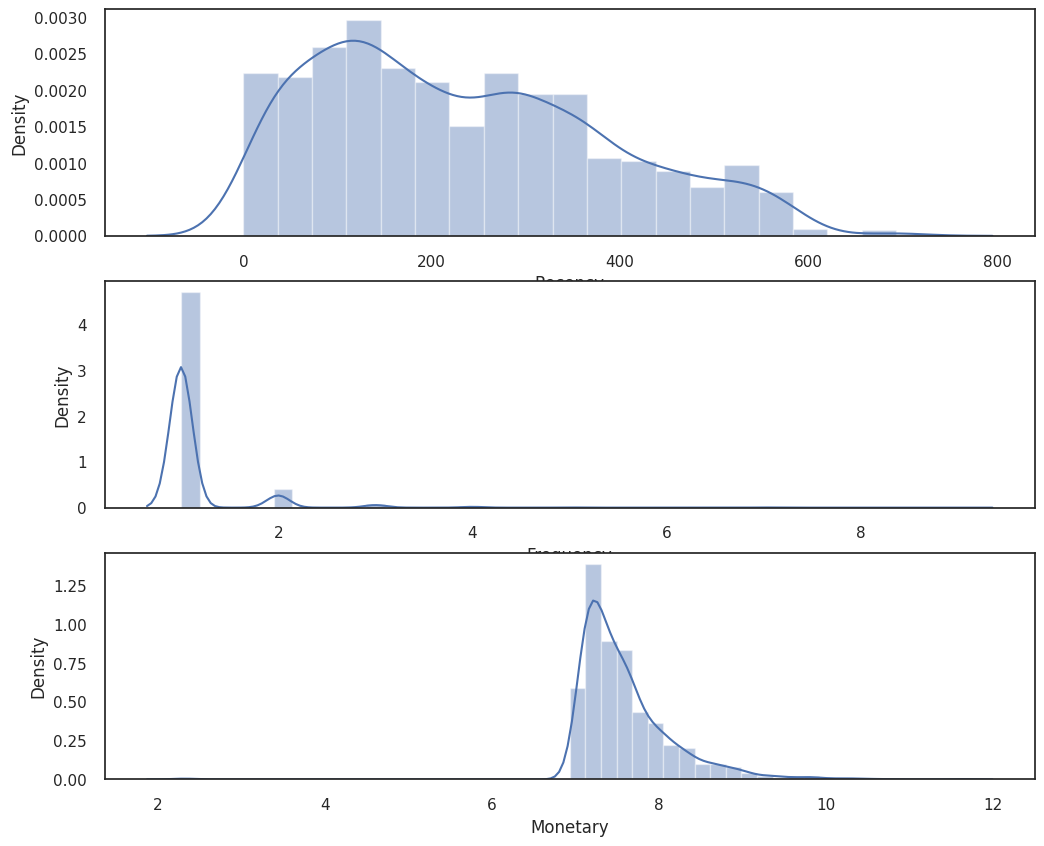

In [ ]:
#outliers distirbution

plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(outliers['Recency'])
plt.subplot(3, 1, 2); sns.distplot(outliers['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(outliers['Monetary'])
plt.show()

# SCALING

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Select the columns to be scaled
columns_to_scale = ['Recency', 'Frequency', 'Monetary']

# Create a new DataFrame with the selected columns
RFM_log_trans_wo_scaled = RFM_log_trans_wo[['customer_unique_id'] + columns_to_scale].copy()

# Apply min-max scaling to the selected columns
scaler = MinMaxScaler()
RFM_log_trans_wo_scaled[columns_to_scale] = scaler.fit_transform(RFM_log_trans_wo_scaled[columns_to_scale])

# Print the updated RFM_log_trans_wo_scaled DataFrame
print(RFM_log_trans_wo_scaled)



                     customer_unique_id   Recency  Frequency  Monetary
0      0000366f3b9a7992bf8c76cfdf3221e2  0.160870        0.0  0.544907
1      0000b849f77a49e4a4ce2b2a4ca5be3f  0.165217        0.0  0.184994
2      0000f46a3911fa3c0805444483337064  0.776812        0.0  0.436380
3      0000f6ccb0745a6a4b88665a16c9f078  0.463768        0.0  0.287954
4      0004aac84e0df4da2b147fca70cf8255  0.415942        0.0  0.616250
...                                 ...       ...        ...       ...
91444  fffb09418989a0dbff854a28163e47c6  0.368116        0.0  0.400601
91446  fffea47cd6d3cc0a88bd621562a9d061  0.378261        0.0  0.432196
91447  ffff371b4d645b6ecea244b27531430a  0.821739        0.0  0.494256
91448  ffff5962728ec6157033ef9805bacc48  0.171014        0.0  0.531924
91449  ffffd2657e2aad2907e67c3e9daecbeb  0.700000        0.0  0.395784

[89498 rows x 4 columns]


## VALIDATION FUNCTIONS


In [ ]:
#ELBOW ANALYSIS FUNCTION
#KMEANS

def elbow_method_kmeans(X, k_values):
    distortions = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='random')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(k_values, distortions, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.xticks(k_values)  # Set x-axis ticks to match k_values
    plt.show()

#KMEANS++
def elbow_method_kmeans_plusplus(X, k_values):
    distortions = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(k_values, distortions, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.show()



#SILHOUTTE ANALYSIS FUNCTION
#K MEANS


import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

def perform_kmeans_analysis(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    range_n_clusters = list(range(2, 10))  # Update the range from 2 to 10

    silhouette_scores = []
    num_clusters = []

    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='random')
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

        silhouette_scores.append(silhouette_avg)
        num_clusters.append(n_clusters)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.figure()
    plt.plot(num_clusters, silhouette_scores, 'bo-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.title("Silhouette score vs. Number of clusters")
    plt.show()


#KMEANS++
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

def perform_rfm_analysis_updated(X):
    range_n_clusters = list(range(2, 10))  # Update the range from 2 to 10

    silhouette_scores = []
    num_clusters = []

    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

        silhouette_scores.append(silhouette_avg)
        num_clusters.append(n_clusters)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.figure()
    plt.plot(num_clusters, silhouette_scores, 'bo-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.title("Silhouette score vs. Number of clusters")
    plt.show()




## K-MEANS

In [ ]:
#Elbow Analysis
k_values = [2, 3, 4, 5, 6, 8, 9, 10]
elbow_method_kmeans(selected_columns_kmeans, k_values)

NameError: ignored

In [ ]:
## WITH STANDARD SCALING
perform_kmeans_analysis(RFM_log_trans_wo_scaled[['Recency','Frequency','Monetary']])

## K-MEANS++

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

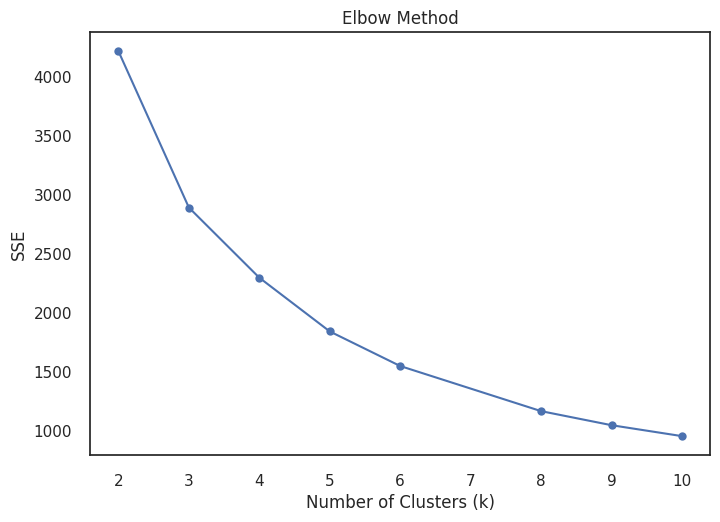

In [ ]:
#Elbow Analysis
k_values = [2, 3, 4, 5, 6, 8, 9, 10]
elbow_method_kmeans_plusplus(RFM_log_trans_wo_scaled[['Recency','Frequency','Monetary']], k_values)

In [ ]:
#MIN MAX SCALING
#Elbow Analysis
k_values = [1, 2, 3, 4, 5, 6, 8, 9]
elbow_method_kmeans_plusplus(RFM_log_trans_wo_scaled[['Recency','Frequency','Monetary']], k_values)


In [ ]:
#WITH MIN MAX SCALING
perform_rfm_analysis_updated(RFM_log_trans_wo_scaled[['Recency','Frequency','Monetary']])

In [ ]:
import matplotlib.pyplot as plt

# Define the number of clusters
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

# Define the silhouette scores
silhouette_scores = [0.3809064444844298, 0.36040439174286826, 0.33875567560068126,
                     0.33723278917798466, 0.3421220584055651, 0.3391020695395609,
                     0.3359770739802898, 0.3344405858090838]

# Plot the silhouette scores
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs. Number of Clusters')
plt.show()



In [ ]:
#WITH MIN MAX SCALING
perform_rfm_analysis_updated(rfm_scaled_df)

In [ ]:
#WITH MIN MAX SCALING
perform_rfm_analysis_updated(rfm_scaled_df)


In [ ]:
## WITH STANDARD SCALING
perform_rfm_analysis_updated(selected_columns_kmeans)

In [ ]:
## WITH STANDARD SCALING
perform_rfm_analysis_updated(rfm_scaled_df[['Recency_scaled','Monetary_scaled']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


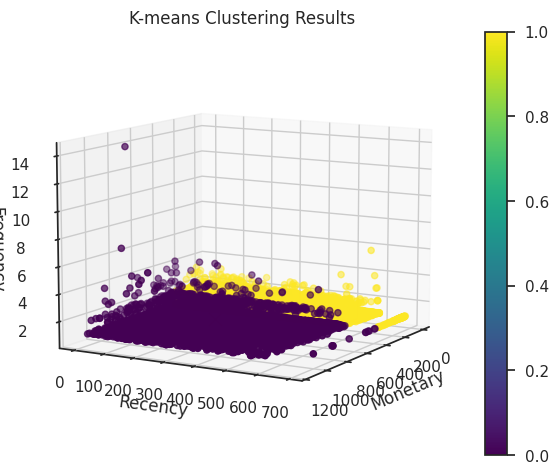

                     customer_unique_id RFMClass  Recency  Frequency  \
0      0000366f3b9a7992bf8c76cfdf3221e2      454      111          1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      451      114          1   
2      0000f46a3911fa3c0805444483337064      152      536          1   
3      0000f6ccb0745a6a4b88665a16c9f078      251      320          1   
4      0004aac84e0df4da2b147fca70cf8255      254      287          1   
...                                 ...      ...      ...        ...   
89493  fffb09418989a0dbff854a28163e47c6      352      254          1   
89494  fffea47cd6d3cc0a88bd621562a9d061      352      261          1   
89495  ffff371b4d645b6ecea244b27531430a      153      567          1   
89496  ffff5962728ec6157033ef9805bacc48      453      118          1   
89497  ffffd2657e2aad2907e67c3e9daecbeb      152      483          1   

       Monetary  Cluster  
0        141.90        1  
1         27.19        1  
2         86.22        1  
3         43.62        1  


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Assuming RFM_log_trans_wo_scaled is your DataFrame
# Assuming num_clusters is the desired number of clusters

# Perform k-means clustering with K-means++ initialization
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(RFM_log_trans_wo_scaled[['Recency','Frequency','Monetary']])

# Get the cluster labels and cluster centers
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with color-coded clusters
scatter = ax.scatter(RFM_log_trans_wo_scaled['Monetary'], RFM_log_trans_wo_scaled['Recency'], RFM_log_trans_wo_scaled['Frequency'], c=cluster_labels, cmap='viridis')

# Scatter plot the cluster centers
ax.scatter(cluster_centers[:, 2], cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100)

# Set labels and title
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_title('K-means Clustering Results')

# Set the viewing angle
ax.view_init(azim=30, elev=10)  # Adjust the azim and elev angles to change the viewing angle

# Create a colorbar legend
plt.colorbar(scatter)

# Show the plot
plt.show()

# Add the cluster_labels as a new column in the DataFrame
RFM_log_trans_wo_scaled['Cluster'] = cluster_labels

# Display the updated DataFrame
print(RFM_log_trans_wo_scaled)


In [ ]:
# Count of missing Values
print(" \nCount of missing values : \n\n",
      RFM_log_trans_wo_scaled.isnull().sum())

 
Count of missing values : 

 customer_unique_id    0
Recency               0
Frequency             0
Monetary              0
dtype: int64


In [ ]:
RFM_log_trans_wo_scaled

,customer_unique_id,RFMClass,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,454,111,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,451,114,1,27.19,1
2,0000f46a3911fa3c0805444483337064,152,536,1,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,251,320,1,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,254,287,1,196.89,1
...,...,...,...,...,...,...
89493,fffb09418989a0dbff854a28163e47c6,352,254,1,73.16,1
89494,fffea47cd6d3cc0a88bd621562a9d061,352,261,1,84.58,1
89495,ffff371b4d645b6ecea244b27531430a,153,567,1,112.46,1
89496,ffff5962728ec6157033ef9805bacc48,453,118,1,133.69,1


In [ ]:
RFM_log_trans_wo_scaled = RFM_log_trans_wo_scaled.merge(RFM_df[['customer_unique_id', 'Recency', 'Frequency', 'Monetary','RFMClass']], on='customer_unique_id', how='left')
RFM_log_trans_wo_scaled[['Recency', 'Frequency', 'Monetary']] = RFM_log_trans_wo_scaled[['Recency_y', 'Frequency_y', 'Monetary_y']]
RFM_log_trans_wo_scaled.drop(['Recency_x', 'Frequency_x', 'Monetary_x', 'Recency_y', 'Frequency_y', 'Monetary_y'], axis=1, inplace=True)
RFM_log_trans_wo_scaled

,customer_unique_id,RFMClass_x,Cluster,RFMClass_y,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,454,1,454,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,451,1,451,114,1,27.19
2,0000f46a3911fa3c0805444483337064,152,1,152,536,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,251,1,251,320,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,254,1,254,287,1,196.89
...,...,...,...,...,...,...,...
89493,fffb09418989a0dbff854a28163e47c6,352,1,352,254,1,73.16
89494,fffea47cd6d3cc0a88bd621562a9d061,352,1,352,261,1,84.58
89495,ffff371b4d645b6ecea244b27531430a,153,1,153,567,1,112.46
89496,ffff5962728ec6157033ef9805bacc48,453,1,453,118,1,133.69


In [ ]:
outliers = outliers.merge(RFM_df[['customer_unique_id', 'Recency', 'Frequency', 'Monetary','RFMClass']], on='customer_unique_id', how='left')
outliers[['Recency', 'Frequency', 'Monetary']] = outliers[['Recency_y', 'Frequency_y', 'Monetary_y']]
outliers.drop(['Recency_x', 'Frequency_x', 'Monetary_x', 'Recency_y', 'Frequency_y', 'Monetary_y'], axis=1, inplace=True)
outliers.describe()

,Cluster,Recency,Frequency,Monetary
count,1806.0,1806.000000,1806.000000,1806.000000
mean,4.0,232.385382,1.142857,2495.197863
std,0.0,152.708325,0.522694,3662.882670
min,4.0,0.000000,1.000000,9.590000
25%,4.0,108.000000,1.000000,1348.135000
50%,4.0,209.000000,1.000000,1692.320000
75%,4.0,340.000000,1.000000,2429.650000
max,4.0,693.000000,9.000000,109312.640000


In [ ]:
outliers.describe()

,Cluster,Recency,Frequency,Monetary
count,1806.0,1806.000000,1806.000000,1806.000000
mean,4.0,232.385382,1.142857,2495.197863
std,0.0,152.708325,0.522694,3662.882670
min,4.0,0.000000,1.000000,9.590000
25%,4.0,108.000000,1.000000,1348.135000
50%,4.0,209.000000,1.000000,1692.320000
75%,4.0,340.000000,1.000000,2429.650000
max,4.0,693.000000,9.000000,109312.640000


In [ ]:
concatenated_df = pd.concat([RFM_log_trans_wo_scaled, outliers], axis=0)
concatenated_df2 = pd.concat([concatenated_df, outliers2], axis=0)
concatenated_df2.describe()


,Cluster,Recency,Frequency,Monetary
count,91450.000000,91450.000000,91450.000000,91450.000000
mean,0.959923,236.054073,1.032859,211.928600
std,0.533886,152.541250,0.206200,631.315969
min,0.000000,0.000000,1.000000,2.924236
25%,1.000000,113.000000,1.000000,63.600000
50%,1.000000,217.000000,1.000000,112.620000
75%,1.000000,344.000000,1.000000,202.120000
max,4.000000,694.000000,14.000000,109312.640000


In [ ]:
concatenated_df['Cluster'].value_counts()

1    80123
0     9375
4     1806
Name: Cluster, dtype: int64

In [ ]:

# Group by 'Cluster' and calculate the averages
cluster_averages = concatenated_df2.groupby('Cluster')['Recency', 'Frequency', 'Monetary'].mean()

# Calculate the overall averages
overall_averages = concatenated_df2[['Recency', 'Frequency', 'Monetary']].mean()

# Get the size of each cluster
cluster_sizes = concatenated_df2['Cluster'].value_counts().rename('Cluster Size')

# Create a new DataFrame to display the results
result_df = pd.concat([cluster_averages, cluster_sizes], axis=1)
result_df.loc['Overall'] = pd.Series({**overall_averages.to_dict(), 'Cluster Size': len(concatenated_df2)})

# Display the result table
print(result_df)


            Recency  Frequency     Monetary  Cluster Size
0        233.977280   1.101973   579.388689        9375.0
1        235.548207   1.022341   117.844565       80123.0
3        692.404110   1.006849     4.890681         146.0
4        232.385382   1.142857  2495.197863        1806.0
Overall  236.054073   1.032859   211.928600       91450.0


<ipython-input-175-b43daa1f2498>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_averages = concatenated_df2.groupby('Cluster')['Recency', 'Frequency', 'Monetary'].mean()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'Cluster' column to integer
concatenated_df['Cluster'] = concatenated_df['Cluster'].astype(int)

# Dictionary mapping cluster IDs to names
cluster_names = {
    0: 'Cluster C1',
    1: 'Cluster C2',
    2: 'Cluster C3',
    3: 'Cluster C4',
    5: 'Cluster C5',
}

# Group the DataFrame by Cluster and RFMClass and calculate the count
grouped = concatenated_df.groupby(['Cluster', 'RFMClass']).size().reset_index(name='Count')

# Calculate the total count for each cluster
cluster_totals = grouped.groupby('Cluster')['Count'].sum().reset_index(name='Total')

# Filter out RFMClass categories with less than 2% count within each cluster
filtered_grouped = grouped.merge(cluster_totals, on='Cluster')
filtered_grouped['Percentage'] = filtered_grouped['Count'] / filtered_grouped['Total']
filtered_grouped.loc[filtered_grouped['Percentage'] < 0.052, 'RFMClass'] = 'Other'

# Get unique clusters
clusters = filtered_grouped['Cluster'].unique()

# Create subplots for each cluster with larger size
num_clusters = len(clusters)
fig, axs = plt.subplots(num_clusters, 1, figsize=(8, 6*num_clusters))

# Iterate over clusters and create a pie chart for each
for i, cluster in enumerate(clusters):
    # Filter the grouped data for the current cluster
    cluster_data = filtered_grouped[filtered_grouped['Cluster'] == cluster]
    rfm_classes = cluster_data['RFMClass']
    counts = cluster_data['Count']

    # Calculate the count for the "Other" category within the current cluster
    other_count = counts[rfm_classes == 'Other'].sum()

    # Append the "Other" count to the counts array
    counts = counts[rfm_classes != 'Other'].append(pd.Series(other_count, index=['Other']))

    # Append the "Other" label to the rfm_classes array
    rfm_classes = rfm_classes[rfm_classes != 'Other'].append(pd.Series('Other'))

    # Sort the counts and rfm_classes arrays in descending order
    counts, rfm_classes = zip(*sorted(zip(counts, rfm_classes), reverse=True))

    # Create the pie chart with larger size
    axs[i].pie(counts, labels=rfm_classes, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(cluster_names.get(cluster, f'Cluster {cluster}'))

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()





In [ ]:
RFM_log_trans_wo_scaled.describe()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming concatenated_df is the DataFrame with "Recency", "Frequency", "Monetary", and "Cluster" columns

# Create a larger figure
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels
clusters = RFM_log_trans_wo_scaled['Cluster'].unique()

# Assign a different color to each cluster
colors = plt.cm.viridis(clusters / max(clusters))

# Scatter plot the data points with color-coded clusters
for cluster, color in zip(clusters, colors):
    cluster_data = RFM_log_trans_wo_scaled[RFM_log_trans_wo_scaled['Cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], cluster_data['Monetary'], c=color, label=f'Cluster {cluster}', s=1)  # Adjust the value of s to make the dots smaller

# Set labels and title
ax.set_xlabel('Frequency ')
ax.set_ylabel('Recency ')
ax.set_zlabel('Monetary')
#ax.set_title('3D Plot of RFM Variables Grouped by Clusters')
ax.legend()

# Set the range of each axis
ax.set_xlim3d(0, 5)  # Modify the range of the x-axis
ax.set_ylim3d(800, 0)  # Modify the range of the y-axis
ax.set_zlim3d(0, 1100)  # Modify the range of the z-axis

# Set the viewing angl
ax.view_init(azim=60, elev=20)

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming RFM_log_trans_wo_scaled is the DataFrame with "Recency", "Frequency", "Monetary", and "Cluster" columns

# Create a larger figure
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels
clusters = RFM_log_trans_wo_scaled['Cluster'].unique()

# Assign a different color to each cluster
colors = plt.cm.viridis(clusters / max(clusters))

# Scatter plot the data points with color-coded clusters
for cluster, color in zip(clusters, colors):
    cluster_data = RFM_log_trans_wo_scaled[RFM_log_trans_wo_scaled['Cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], cluster_data['Monetary'], c=color, label=f'Cluster {cluster}', s=1)  # Adjust the value of s to make the dots smaller

# Set labels and title
ax.set_xlabel('Frequency', labelpad=10)
ax.set_ylabel('Recency', labelpad=10)
ax.set_zlabel('Monetary', labelpad=10)
#ax.set_title('3D Plot of RFM Variables Grouped by Clusters')
ax.legend()

# Set the range of each axis
ax.set_xlim3d(0, 5)  # Modify the range of the x-axis
ax.set_ylim3d(800, 0)  # Modify the range of the y-axis
ax.set_zlim3d(0, 1100)  # Modify the range of the z-axis

# Set the viewing angle
ax.view_init(azim=60, elev=20)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming concatenated_df is the DataFrame with "Recency", "Frequency", "Monetary", and "Cluster" columns

# Create a larger figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels
clusters = RFM_log_trans_wo_scaled['Cluster'].unique()

# Assign a different color to each cluster
colors = plt.cm.viridis(clusters / max(clusters))

# Scatter plot the data points with color-coded clusters
for cluster, color in zip(clusters, colors):
    cluster_data = RFM_log_trans_wo_scaled[RFM_log_trans_wo_scaled['Cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], cluster_data['Monetary'], c=color, label=f'Cluster {cluster}', s=1)  # Adjust the value of s to make the dots smaller

# Set labels and title
ax.set_xlabel('Frequency', labelpad=7)  # Add space between the x-axis label and the axis
ax.set_ylabel('Recency', labelpad=7)  # Add space between the y-axis label and the axis
ax.set_zlabel('Monetary', labelpad=4)  # Add space between the z-axis label and the axis
#ax.set_title('3D Plot of RFM Variables Grouped by Clusters')
ax.legend()

# Set the range of each axis
ax.set_xlim3d(8, 0)  # Modify the range of the x-axis
ax.set_ylim3d(0, 800)  # Modify the range of the y-axis
ax.set_zlim3d(0, 500)  # Modify the range of the z-axis

# Set the viewing angle
ax.view_init(azim=90, elev=10)

# Show the plot
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Assuming concatenated_df is the DataFrame with "Recency", "Frequency", "Monetary", and "Cluster" columns

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Get unique cluster labels
clusters = RFM_log_trans_wo_scaled['Cluster'].unique()

# Assign a different color to each cluster
colors = plt.cm.viridis(clusters / max(clusters))

# Scatter plot the data points with color-coded clusters
for cluster, color in zip(clusters, colors):
    cluster_data = RFM_log_trans_wo_scaled[RFM_log_trans_wo_scaled['Cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], c=color, label=f'Cluster {cluster}', s=10)  # Adjust the value of s to change the dot size

# Set labels and title
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_title('Recency vs. Monetary')

# Set the range of each axis
ax.set_xlim(0, 8)  # Modify the range of the x-axis
ax.set_ylim(0, 800)  # Modify the range of the y-axis

# Show the legend
#ax.legend()

# Show the plot
plt.show()


In [ ]:
44

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn_extra.cluster import KMedoids




# Define a range of k values
k_values = range(2, 10)

# Initialize an empty list to store the sum of squared distances
ssd = []

# Calculate the sum of squared distances for each value of k
for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=0).fit(RFM_log_trans_wo_scaled[['Recency','Frequency','Monetary']])
    ssd.append(kmedoids.inertia_)

# Plot the elbow curve
plt.plot(k_values, ssd, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve for K-Medoids Clustering')
plt.show()


In [ ]:
#Assing higher level categories for product categories
def categorize_product(row):
    subcategory = row['product_category_name_english']
    if subcategory in ['bed_bath_table', 'furniture_decor', 'home_appliances', 'home_construction', 'home_confort',
                       'kitchen_dining_laundry_garden_furniture', 'furniture_living_room', 'furniture_bedroom',
                       'furniture_mattress_and_upholstery',  'pet_shop', 'flowers', 'home_comfort_2', 'la_cuisine', 'air_conditioning'  ]:
        return 'Home and Furniture'
    elif subcategory in ['health_beauty', 'diapers_and_hygiene', 'perfumery']:

        return 'Health and Beauty'
    elif subcategory in ['sports_leisure', 'toys', 'cool_stuff', 'musical_instruments', 'sports_leisure', 'christmas_supplies', 'party_supplies',
                         'art', 'cine_photo', 'dvds_blu_ray', 'music','cds_dvds_musicals','arts_and_craftmanship']:
        return 'Entertainment'
    elif subcategory in ['computers_accessories', 'electronics', 'office_furniture', 'consoles_games',
                         'tablets_printing_image', 'computers', 'telephony', 'fixed_telephony', 'audio','signaling_and_security',
                         'security_and_services']:

        return 'Technology and Office'
    elif subcategory in ['housewares', 'home_appliances_2', 'small_appliances', 'small_appliances_home_oven_and_coffee']:

        return 'Appliances and Housewares'
    elif subcategory in ['watches_gifts','luggage_accessories', 'luggage_accessories ',
                         'fashion_bags_accessories ', 'fashion_bags_accessories', 'fashion_shoes', 'fashio_female_clothing',
                         'fashion_male_clothing', 'fashion_underwear_beach', 'fashion_childrens_clothes',
                         'fashion_sport','baby']:
        return 'Fashion and Accesories'
    elif subcategory in ['garden_tools', 'construction_tools_construction', 'costruction_tools_garden', 'construction_tools_lights',
                         'costruction_tools_tools', 'construction_tools_safety'
                         ]:
        return 'Garden and Construction'
    elif subcategory in ['auto']:
        return 'Automotive'
    elif subcategory in ['food', 'drinks', 'food_drink']:
        return 'Food and Beverages'
    elif subcategory in ['stationery', 'books_general_interest', 'books_technical', 'books_imported']:
        return 'Books and Stationery'
    elif subcategory in ['industry_commerce_and_business', 'market_place','agro_industry_and_commerce']:
        return 'Business and Industrial'
    else:
        return 'Other'

olist_df['category'] = olist_df.apply(categorize_product, axis=1)

# PRODUCT ANALYSIS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Prepare the data
features = customers_data[['customer_city', 'cluster segment']]
target = customers_data['rfm_behavior']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Build the decision tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
